[kroki-online](https://kroki.io/)

[kroki-python-interface](https://github.com/thorwhalen/kroki)


[d2-doc](https://d2lang.com/tour/text)

[d2-online](https://play.d2lang.com/)

[d2-python-generator](https://github.com/MrBlenny/py-d2)




dot string, graphviz, networkx graph

```python
# %% pygraphviz, slow for windows, not recommended

import pygraphviz as pgv 
pgv_g = pgv.AGraph(dot) # read dot string

import networkx as nx 
g = nx.drawing.nx_agraph.from_agraph(pgv_g)


# %% pydot, non-active package, not recommended
import pydot as dt  
from IPython.display import SVG
dt_g = dt.graph_from_dot_data(dot)[0]  # read dot string, but not a graph 
dt_g = SVG(dt_g.create_svg())

import networkx as nx 
g = nx.nx_pydot.from_pydot(dt_g)


# %% python graphviz
import graphviz as gv  

gv_g = gv.Digraph()
gv_g.body += str(gv.Source(dot)).splitlines()[1:-1]  # read dot string
gv_g

```

In [ ]:
# 这种接口一般是面向熟悉 python 而不熟悉 d2 语法的用户

# from py_d2 import D2Diagram, D2Shape, D2Connection, D2Style

# shapes = [
#     D2Shape(name="shape_name1", style=D2Style(fill="red")),
#     D2Shape(name="shape_name2", style=D2Style(fill="blue"))]
# connections = [
#     D2Connection(shape_1="shape_name1", shape_2="shape_name2")
# ]

# diagram = D2Diagram(shapes=shapes, connections=connections)

# with open("graph.d2", "w", encoding="utf-8") as f:
#     f.write(str(diagram))


In [29]:
import ast 
from pathlib import Path 

def module2path(mod_name, root):
    return root/Path(*mod_name.split('.')).with_suffix('.py')

def path2module(path, root='.'):
    def str2abs(p): return Path(p).absolute()
    rel_path = str2abs(path).relative_to(str2abs(root))
    return '.'.join(rel_path.with_suffix("").parts)

# def psplit(path, sep='.'):
#     p = path.split(sep)
#     return [sep.join(p[:i+1]) for i, _ in enumerate(p)]

# def module2relpath(mod_name):
#     return Path(*mod_name.split('.')).with_suffix('.py')

# def del_init(mod_name):
#     if mod_name.endswith(".__init__") :
#         return mod_name.replace('.__init__', '') 
#     return mod_name 
    
# def add_init(mod_name):
#     if mod_name.endswith(".__init__"):
#         return mod_name 
#     return f"{mod_name}.__init__"

def imps_from_file(path, root):
    code = path.read_text(encoding="utf8")
    mod_ast = ast.parse(source=code, filename=path)
    # (where, imported, asname, level)
    importeds = set()
    for node in ast.walk(mod_ast):
        # parse
        if isinstance(node, ast.Import):
            for n_ast in node.names:
                imported = (None, n_ast.name, n_ast.asname, None)
        elif isinstance(node, ast.ImportFrom):
            # display(ast.dump(node))
            for n_ast in node.names:
                imported = (node.module, n_ast.name, n_ast.asname, node.level)
        else:
            continue   
        # translate
        where, imported_name, _, level = imported
        if level is None:
            imp = imported_name
        elif level == 0:
            imp = f"{where}.{imported_name}"
        else: 
            pa_mod = path2module(Path(*path.parts[:-level]), root)
            imp = f"{pa_mod}.{where}.{imported_name}"
        importeds.add(imp)
    return importeds

def get_imps(
    root:str='.', project:str='',
    agg_external:bool = True, # aggregate external modules
    agg_internal:bool = True # aggregate internal modules
    ):
    mod2path = {}
    mod2imp_in, mod2imp_ex = {}, {}
    mod2imppath_in = {} 
    # todo: mod2imppath_ex 
    root = Path(root).absolute()
    for path in (root/project).rglob("*.py"):
        mod = path2module(path, root)
        imps = imps_from_file(path, root) 
        mod2path[mod] = path
        for imp in imps: 
            imp_root = imp.split('.')[0]  # snake root 
            if imp_root == project: # is internal module
                if agg_internal:
                    imp_path = module2path(imp, root)
                    imp = imp if imp_path.exists() else imp.rsplit('.', 1)[0] 
                mod2imp_in.setdefault(mod, set()).add(imp)
                mod2imppath_in.setdefault(mod, set()).add(imp_path)
            else:
                imp = imp_root if agg_external else imp
                mod2imp_ex.setdefault(mod, set()).add(imp) 
    return dict(
        mod2path=mod2path,
        mod2imp_in=mod2imp_in, 
        mod2imp_ex=mod2imp_ex, 
        mod2imppath_in=mod2imppath_in,
    )

class DepGraph:
    def __init__(self, root:str='.', project:str='', **kwargs):
        for k, v in get_imps(root, project, **kwargs).items():
            setattr(self, k, v)
        self.edges = [
            *[(fr, to) for to, frs in self.mod2imp_in.items() for fr in frs],
            *[(fr, to) for to, frs in self.mod2imp_ex.items() for fr in frs],
            ]
        self.nodes = sorted(set().union(*self.edges))
        
    def to_dot(self):
        pass 
    
    def to_d2(self):
        pass 
    
    def to_nx(self):
        pass 
    
    
        
if __name__ == "__main__":
    
    project='certx'
    root = 'd:/Studies/Collections/Projects/certx'
    dg = DepGraph(root, project)


In [30]:
from IPython.display import SVG

class API:
    @staticmethod
    def create_svg(d2:str, app:str='d2') -> SVG:
        if app == 'd2':
            import subprocess
            d2_fname = "_temp.d2"
            with open(d2_fname, 'w', encoding='utf-8') as f:
                f.write(d2)
            output = subprocess.getoutput(f'd2 {d2_fname} - ')
            output = output.rsplit('\n',1)[0]
            res = SVG(output)
        elif app == 'kroki':
            from kroki import diagram_image
            # too slow, 10s
            res = diagram_image(d2, diagram_type='d2', output_format='svg')
        return res

class D2(API):
    def nx2(self, output):
        pass

d2 = D2


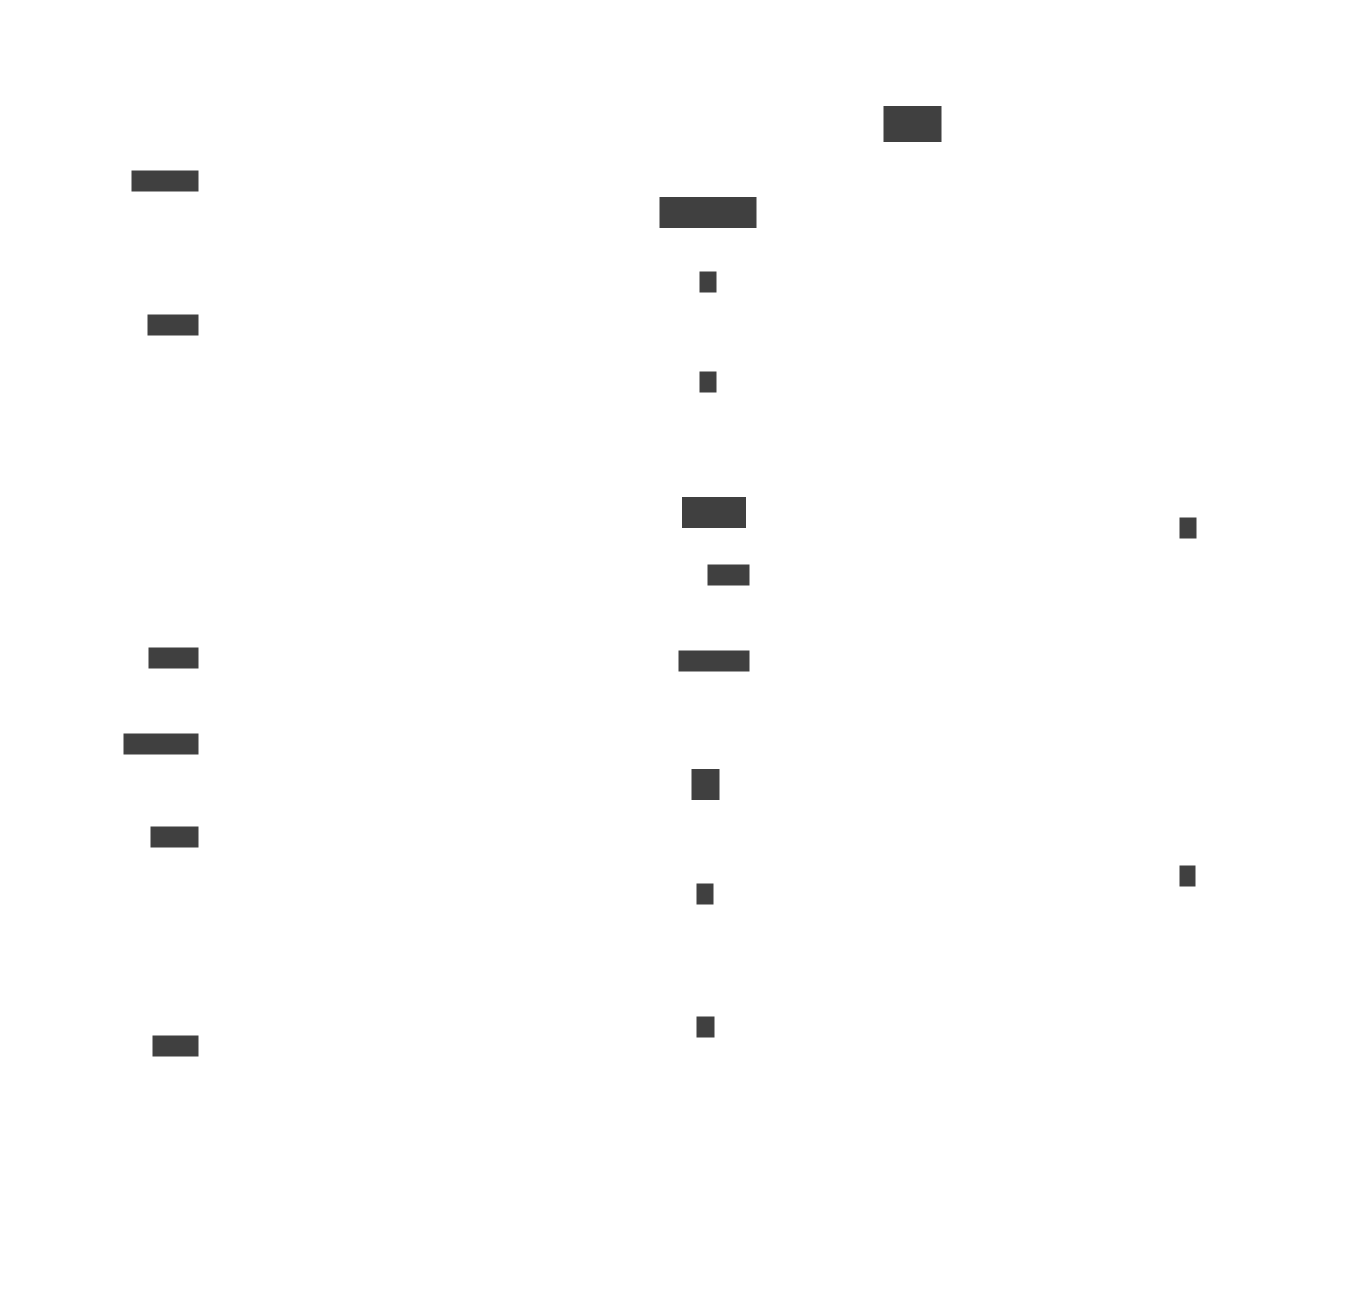

In [42]:
import networkx as nx

g = nx.DiGraph(dg.edges)

# ignores = ['re', 'io', 'itertools', 'argparse', 'IPython', 'pprint']
# ignores += [node for node in g.nodes() if node.endswith(".utils")]
# g.remove_nodes_from(ignores)
e_string = '\n'.join({f"{fr} -> {to}" for fr, to in g.edges})

deletes = ["*.utils", 're', 'io', 'itertools', 'argparse', 'IPython', 'pprint']
deletes_hooks = '\n'.join(f"{i}: null" for i in deletes) if deletes else ""
options = '''
vars: { 
    d2-config: { 
        layout-engine: elk 
        theme-id: 200
        } 
    }
direction: right
**.style.border-radius: 99
'''
# **.shape: oval 
d2_string = f"{options}\n{e_string}\n{deletes_hooks}"
d2.create_svg(d2_string)
# D2API(d2_string).svg('kroki')


In [ ]:
from snakefood3.gen_deps import GenerateDependency

project_name='certx'
root = 'd:/Studies/Collections/Projects/certx'

dot = GenerateDependency(root, project_name).make_dot_file()
dot = "\n".join((dot).split("\n")[3:]).replace('dpi="150",', '')


In [ ]:
from IPython.display import SVG

class API:
    @staticmethod
    def create_svg(d2:str, app:str='d2') -> SVG:
        if app == 'd2':
            import subprocess
            d2_fname = "_temp.d2"
            with open(d2_fname, 'w', encoding='utf-8') as f:
                f.write(d2)
            output = subprocess.getoutput(f'd2 {d2_fname} - ')
            output = output.rsplit('\n',1)[0]
            res = SVG(output)
        elif app == 'kroki':
            from kroki import diagram_image
            # too slow, 10s
            res = diagram_image(d2, diagram_type='d2', output_format='svg')
        return res

class D2(API):
    def nx2(self, output):
        pass

d2 = D2


In [ ]:
import networkx as nx 
import pydot as dt 

g = nx.nx_pydot.from_pydot(dt.graph_from_dot_data(dot)[0])


# ignores = ['re', 'io', 'itertools', 'argparse']
# ignores += [node for node in g.nodes() if node.endswith(".utils")]
# g.remove_nodes_from(ignores)

# agg external packages
replaces = [(n.split('.')[0], n) for n in g.nodes 
            if "." in n and project_name not in n]
replaces = []
res = set()
for fr, to, _ in g.edges:
    if replaces:
        for root, desc in replaces:
            fr = fr.replace(desc, root)
    res |= {f"{fr} -> {to}"}
    
e_string = '\n'.join(res)

deletes = ["*.utils", 're', 'io', 'itertools', 'argparse']
deletes = []
deletes_hooks = '\n'.join(f"{i}: null" for i in deletes) if deletes else ""

options = '''
vars: { 
    d2-config: { 
        layout-engine: elk 
        theme-id: 200
        } 
    }
direction: right
**.style.border-radius: 99
'''
# **.shape: oval 

d2_string = f"{options}\n{e_string}\n{deletes_hooks}"

# D2API(d2_string).svg('kroki')
d2.create_svg(d2_string)
